The `analysis` module offers a number of scripts, ranging from simple checks of slab thickness and atom movement to plotting the electrostatic potenital through the slab. The module relies heavily on the `pymatgen.analysis.local_env` module so caution should be exercised before using the bond analysis and nearest neighbours functionalities with default settings. 

In [1]:
from surfaxe.analysis import cart_displacements, bond_analysis, \
electrostatic_potential, simple_nn, complex_nn, slab_thickness

### Bond analysis 
Consistent bond lengths in c-direction in the relaxed slab are an indicator of a sufficient slab thickness. The `bond_analysis` function takes the slab structure file and the atom pairs under consideration to asses the bonding distance using the `CrystalNN` algorithm. The validity of the nearest neighbour finding algorithm should be checked on the bulk structure as some struggle with more complex systems - `CrystalNN` and `MinimumDistanceNN` are a good start. As in other modules, oxidation states are added by guess by default, but can be added by element or site as well. 

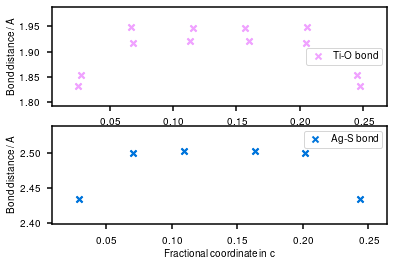

In [3]:
bond_analysis(structure='./CONTCAR_LTA_010', bonds=[('Ti', 'O'), ('Ag', 'S')])

The data collected is plotted at the same time the function is called using the flag `save_plt=True`, which produces the plot above. Some deviation is expected in bond length close to the surface - however the extrapolated line should be relatively flat in the bulk-like region. 

### Electrostatic potential

`Surfaxe` can plot the electrostatic potential going through the slab using the aptly named `electrostatic_potential` function. It calculates both the planar and macroscopic potential - if the latter is flat it can be used to derive the ionisation potential and electron affintity directly. Along with the plot, a .csv file is produced to allow for easier extraction of the vacuum energy. 

The planar potential is just the average along one axis, calculated with pymatgen. The default axis specified here is c (but can be a or b as well) because we are interested in the potential in the vacuum region. The macroscopic potential is a rolling average of the planar potential with the periodicity of the unit cell as the window of the rolling average. The window is calculated as the ratio of the periodicity of the bulk system (`lattice_vector`) and the resolution of the raw potential data in that direction. The latter is calculated by diving the lattice parameter by the dimension of the potential data in a specified direction. 


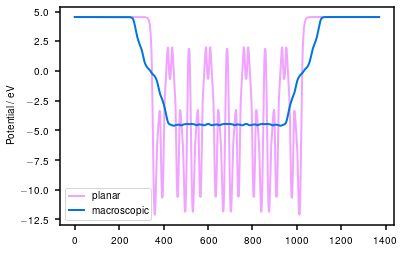

In [5]:
electrostatic_potential(lattice_vector=11.5, locpot=r'./LOCPOT', save_plt=True)

### Coordination environment
The analysis of coordination environment is an important for various reasons in both bulk and surface calculations. 
This [paper](https://chemrxiv.org/articles/Benchmarking_Coordination_Number_Prediction_Algorithms_on_Inorganic_Crystal_Structures/12508229?file=23211761) explains how the coordination number prediction algorithms work and why `CrystalNN` is a good start for most purposes. It is recommended the vaidity of the algorithms is checked with bulk structure before using it in slabs, in particular in the case of metal-sulphur bonding in solid state. Based on anecdotal evidence, most algorithms struggle with bonding environments near the surface in quaternary and quinary systems.  

In `Surfaxe` the coordination environment is separated into `simple_nn` and `complex_nn`. The `simple_nn` function uses `CrystalNN` by default but it can be used with any local environment algorithm. It is fast and intended for simple binaries and ternaries and bulk structures. The `complex_nn` uses the `CutOffDictNN` algorithm where the maximum bond distance needs to be specified in form of a dictionary of bond lengths. It is a slightly slower approach more suited for systems with complex bonding structure, or where other algorithms fail. 

In [9]:
simple_nn(start='./POSCAR_SnO', 
          elements=['Sn', 'O'],
          save_csv=False,
          csv_fname='SnO_nn.csv')

,site_index,site,cn_start,nn_start
0,1,"(Sn, 1)",4,O O O O
1,2,"(Sn, 2)",4,O O O O
2,3,"(Sn, 3)",4,O O O O
3,4,"(Sn, 4)",4,O O O O
4,5,"(Sn, 5)",4,O O O O
5,6,"(Sn, 6)",4,O O O O
6,7,"(O, 1)",4,Sn Sn Sn Sn
7,8,"(O, 2)",4,Sn Sn Sn Sn
8,9,"(O, 3)",4,Sn Sn Sn Sn
9,10,"(O, 4)",4,Sn Sn Sn Sn


In [15]:
complex_nn(start='./POSCAR_LTA_010', 
           elements=['La', 'Ag', 'Ti', 'O', 'S'], 
           cut_off_dict={('Ag','S'): 3.09,
                          ('La','O'): 2.91,
                          ('La','S'): 3.559,
                          ('Ti','O'): 2.35,
                          ('Ti','S'): 2.91,}, 
           txt_fname='LTA_nn.txt')

### Miscellaneous 
might take these two bits out idk how useful they are

In [3]:
slab_thickness(start='POSCAR_LTA_010', end='./CONTCAR_LTA_010')

The initial slab thickness is 9.837 Å. The final slab thickness is 10.296 Å. The difference between the two is -0.458 Å


In [2]:
cart_displacements(start='./POSCAR_LTA_010', end='./CONTCAR_LTA_010', elements=['La','Ti','Ag','S','O'])